BerkeleyX: Data8.2x

Foundations of Data Science: Inferential Thinking by Resampling

In [1]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Lab 4: Inference and Capital Punishment, Part 2

Does instituting a death penalty for murder actually reduce the number of murders?

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

In [2]:
# as seen in part 1:

murder_rates = Table.read_table('../../data/crime_rates.csv').select(
    'State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates, 2) > 0) - np.count_nonzero(diff_n(rates, 2) < 0)

**Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

**Alternative Hypothesis**: State murder rates are more likely to increase over two-year periods.

**Test Statistic**: The number of increases minus the number of decreases

1: The death penalty

A Natural Experiment

**Population:** All the states that had the death penalty before the 1972 abolition. This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

**Treatment group:** The states in that population, in the year after 1972.

**Control group:** The states in that population, in the year before 1972.

**Null hypothesis:** Each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period.  (Whether the murder rate increased or decreased in each state was like the flip of a fair coin.)

**Alternative hypothesis:** The murder rate was more likely to increase.

In [3]:
non_death_penalty_states = np.array(['Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota'])

def had_death_penalty_in_1971(state):
    """True if the state had the death penalty in 1971."""
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
print(death_penalty)

State       | Death Penalty
Alabama     | True
Alaska      | False
Arizona     | True
Arkansas    | True
California  | True
Colorado    | True
Connecticut | True
Delaware    | True
Florida     | True
Georgia     | True
... (40 rows omitted)


In [4]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

44

In [5]:
# Question 1.3
# Assign death_penalty_murder_rates to a table with the same columns and data as murder_rates,
# but that has only the rows for states that had the death penalty in 1971
death_penalty_murder_rates = murder_rates.where(
    'State', are.not_contained_in(non_death_penalty_states))
death_penalty_murder_rates

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


In [6]:
# Question 1.4. 
# Assign test_stat_72 to the value of the test statistic for the years 1971 to 1973
# using the states in death_penalty_murder_rates
good_years = death_penalty_murder_rates.where('Year', are.between_or_equal_to(1971, 1973))
up_or_down = good_years.group('State', two_year_changes).column(3)
test_stat_72 = np.count_nonzero(up_or_down > 0)- np.count_nonzero(up_or_down < 0)
print('Test statistic from 1971 to 1973:', test_stat_72)

Test statistic from 1971 to 1973: 22


In [7]:
# Question 1.5. 
# Draw an empirical histogram of the statistic under the null hypothesis
# by simulating the test statistic 10,000 times
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of your
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    uniform = Table().with_columns(
        "Change", make_array('Increase', 'Decrease'),
        "Chance", make_array(0.5,        0.5))
    sample = uniform.sample_from_distribution('Chance', num_chances_to_change)
    return sample.column(2).item(0) - sample.column(2).item(1)

iterations = 10_000

samples = np.empty(iterations, np.int16)
for i in range(iterations):
    samples[i] = simulate_under_null(num_death_penalty_states)

samples

array([ 2, -2,  0, ...,  2,  0, -4], dtype=int16)

P-value: 0.0005


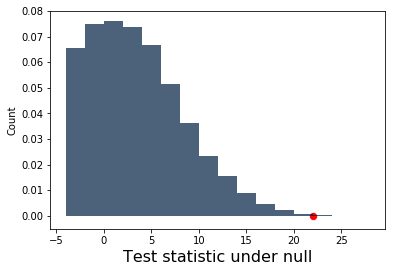

In [8]:
Table().with_column('Test statistic under null', samples).hist(
    bins=np.arange(-4, 28+2, 2), normed=None, density=True)
plt.scatter(test_stat_72, 0, color='red', s=40);
print('P-value:', np.count_nonzero(samples>=test_stat_72)/iterations)

2: Further evidence

- Select a table containing murder rates for certain states and all years,
- Choose two years and compute the observed value of the test statistic,
- Simulate the test statistic under the null hypothesis that increases and decreases are drawn uniformly at random, then
- Compare the observed difference to the empirical distribution to compute a P-value.

In [9]:
def run_test(rates, start_year):
    """Prints out the observed test statistic and returns a P-value 
    for this statistic under the null hypothesis
    Parameters
    ----------
    rates : Table
       A table of murder rates for certain states, sorted by state and year like murder_rates
    start_year : int
       The year when the analysis starts
    """
    end_year = start_year + 2
    observed_test_statistic = sum(rates.where(
        'Year', are.between_or_equal_to(start_year, end_year)).select(
        'State', 'Murder Rate').group('State', two_year_changes).column(1))
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    
    samples = []
    for i in np.arange(5000):
        samples.append(simulate_under_null(num_states))
    samples = np.array(samples) # Convert from a list to an array
    
    if observed_test_statistic > 0:
        return sum(samples >= observed_test_statistic) / len(samples)
    elif observed_test_statistic < 0:
        return sum(samples <= observed_test_statistic) / len(samples)
    
run_test(death_penalty_murder_rates, 1971)

Test statistic 1971 to 1973 : 22


0.001

The rest of the states

In [10]:
# Question 2.1
# Create a table called non_death_penalty_murder_rates 
#  with the same columns as murder_rates but only containing rows 
#  for the six states without the death penalty in 1971.
# Perform the same test on this table.
# Then, set reject_null_2 to whether their murder rates
#  were also more likely to increase from 1971 to 1973
non_death_penalty_murder_rates = murder_rates.where(
    'State', are.contained_in(non_death_penalty_states))

gy_2 = non_death_penalty_murder_rates.where('Year', are.between(1971, 1974))
ud_2 = gy_2.group('State', two_year_changes).column(3)
ts_2 = np.count_nonzero(ud_2 > 0)- np.count_nonzero(ud_2 < 0)
print('Test statistic from 1971 to 1973:', ts_2)

Test statistic from 1971 to 1973: 1


The death penalty reinstated

In [11]:
print("Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states:",
      sum(death_penalty_murder_rates.where('Year', are.between_or_equal_to(1975, 1977))
                                    .group('State', two_year_changes)
                                    .column("Murder Rate two_year_changes")))
run_test(death_penalty_murder_rates, 1975)

Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states: -18
Test statistic 1975 to 1977 : -18


0.0038

3: Visualization

In [12]:
# Question 3.1
# Create a table called average_murder_rates with 1 row for each year in murder_rates.
# It should have 3 columns:
#  Year
#  Death penalty states, the average murder rate of the states that had the death penalty in 1971
#  No death penalty states, the average murder rate of the other states
# average_murder_rates should be sorted in increasing order by year
average_murder_rates = Table().with_columns(
    'Year', murder_rates.group('Year').column(0),
    'Death penalty states', murder_rates.where(
        'State', are.not_contained_in(non_death_penalty_states)).group('Year', np.mean).column(3),
    'No death penalty states', murder_rates.where(
        'State', are.contained_in(non_death_penalty_states)).group('Year', np.mean).column(3))
average_murder_rates

Year,Death penalty states,No death penalty states
1960,5.27955,3.55
1961,4.77727,3.68333
1962,4.61591,2.33333
1963,4.61364,2.75
1964,4.71136,3.4
1965,4.82727,3.18333
1966,5.43182,4.51667
1967,5.875,3.73333
1968,6.27045,4.73333
1969,6.50227,4.73333


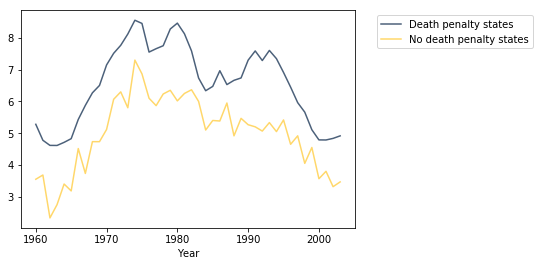

In [13]:
average_murder_rates.plot('Year')

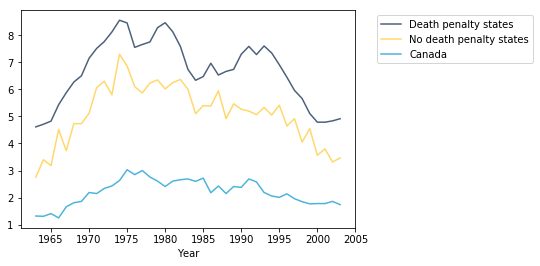

In [14]:
canada = Table.read_table('../../data/canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')